\
Использована предобученная модель [Hiroki Taniai](https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn) \

Установим библиотеку для определения лиц.

In [1]:
!pip install mtcnn

    100% |████████████████████████████████| 2.3MB 10.4MB/s ta 0:00:01
You are using pip version 19.0.3, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Идея работы FaceNet:
1. Выбираем случайное изображение (опорное изображение)
2. Случайно выбираем изображение той же категории (того же человека) что и опорное. (positive example)
3. Случайно выбираем изображение другой категории. (negative example)
4. Пересчитываем параметры FaceNet сети так, чтобы изображения той же категории стали ближе к опорному, а изображения других категорий -- дальше.


$${\displaystyle {\mathcal {L}}\left(A,P,N\right)=\operatorname {max} \left({\|\operatorname {f} \left(A\right)-\operatorname {f} \left(P\right)\|}^{2}-{\|\operatorname {f} \left(A\right)-\operatorname {f} \left(N\right)\|}^{2}+\alpha ,0\right)}$$

$A$ -- опорное изображение(anchor), $P$ -- изображение из той же категории, что и $A$, $N$ --  изображение другой категории, $f$ -- функция вложения, $\alpha$ -- коэфициент для баланса между положительной и отрицательными категориями

In [2]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [3]:
import numpy as np 
import pandas as pd 
import cv2 
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

import os
print(os.listdir("../input"))

['facenet-keras', '5-celebrity-faces-dataset']


Using TensorFlow backend.


Пример картинки

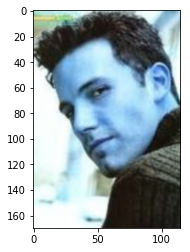

(170, 115, 3)


In [4]:
img = cv2.imread('../input/5-celebrity-faces-dataset/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()
print(img.shape)

Функция extract_face загружает картинку и возвращает извлеченное лицо в виде картинки 160 * 160 пикселей, такая форма нужна для FaceNet модели

Посмотрим как работает extract_face() на примере картинки.

Instructions for updating:
Colocations handled automatically by placer.


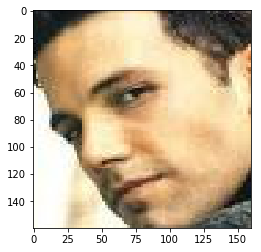

(160, 160, 3)


In [5]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('../input/5-celebrity-faces-dataset/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

Применим extract_face() для всех картинок набора данных (110). 

In [6]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('../input/5-celebrity-faces-dataset/data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('../input/5-celebrity-faces-dataset/data/val/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)
        

loaded 14 sample for class: ben_afflek
loaded 22 sample for class: mindy_kaling
loaded 21 sample for class: jerry_seinfeld
loaded 19 sample for class: madonna
loaded 17 sample for class: elton_john
(93, 160, 160, 3) (93,)
loaded 5 sample for class: ben_afflek
loaded 5 sample for class: mindy_kaling
loaded 5 sample for class: jerry_seinfeld
loaded 5 sample for class: madonna
loaded 5 sample for class: elton_john
(25, 160, 160, 3) (25,)


In [7]:
# загрузим набор лиц
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


Загрузим facenet модель. Она была обучена на наборе данных [MS-Celeb-1M](https://www.microsoft.com/en-us/research/project/ms-celeb-1m-challenge-recognizing-one-million-celebrities-real-world/) и принимает на вход цветные кратинки размера $160*160$, у которых пиксели стандартизованы по всем трем каналам.

In [8]:
# загрузим facenet модель
facenet_model = load_model('../input/facenet-keras/facenet_keras.h5')
print('Loaded Model')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded Model


/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Стандартизуем лица и получим вектора вложения

In [10]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # стандартизация
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # делаем предсказание чтобы получить вектор вложения
    yhat = model.predict(sample)
    return yhat[0]
    
# преобразуем каждое лицо в обучающей выборке в вектора вложения
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# преобразуем каждое лицо в тестовой выборке в вектора вложения
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(93, 128)
(25, 128)


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# нормализация
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# кодируем ответы 
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# обучаем
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# предсказываем
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# оцениваем
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)

print('Точность: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Точность: train=100.000, test=100.000


Посмотрим на конкретное предсказание

[-0.00802511  0.03201871 -0.11638397 -0.05671858  0.01489472 -0.08010466
  0.20442379 -0.05677411 -0.00915256 -0.0689248   0.02958964 -0.03719665
  0.04369466 -0.0996533   0.05749999 -0.00658128 -0.1953651   0.05947034
 -0.02751569  0.00669739  0.06841914 -0.0150333  -0.03528197  0.00613176
 -0.04588779  0.08965464  0.09257529 -0.16633359 -0.10731743  0.07141846
 -0.0170157   0.1429825   0.12742412  0.03769943 -0.09774818  0.04023355
 -0.13292003 -0.066383   -0.14838989 -0.040201    0.18766071  0.03965736
  0.0435473   0.03876213  0.00768882 -0.11364031  0.13171487 -0.01241988
 -0.02936447  0.02293163 -0.02805615 -0.07841825  0.02848684 -0.11182261
  0.11654656 -0.09721268 -0.14319812  0.06589376  0.07199053 -0.03587732
 -0.07323249 -0.08450273 -0.15497659 -0.1139787   0.07687624 -0.08539092
 -0.07303382  0.06041174  0.06751624 -0.01890845  0.01924813 -0.02286419
  0.00726945  0.02932866 -0.20936057 -0.02707871 -0.06184452 -0.05286391
 -0.00356269 -0.11745223  0.02128914  0.01658304 -0

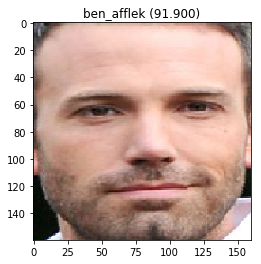

In [55]:
from random import choice
# возьмем случайное лицо
selection = choice([i for i in range(testX.shape[0])])
random_face = testX[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
print(random_face_emd)

# предскажем
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# получим имя
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


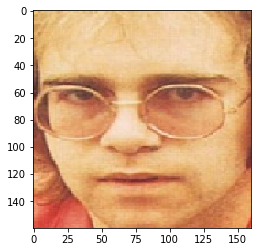

(160, 160, 3)


In [24]:
pixels = extract_face('/kaggle/input/elton-john/john.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

[-0.06058112 -0.0790944  -0.1505104   0.04037639  0.06263606 -0.0338432
  0.0150276  -0.00209638  0.00976445 -0.02625735 -0.00908764  0.1435483
  0.07473604 -0.01600395  0.02255723  0.12323641  0.14246331  0.02288398
  0.01571418  0.07897611  0.12158898 -0.12208845  0.00213478 -0.0560693
  0.01289223 -0.03243634 -0.0654163   0.05206777  0.02325034 -0.07124161
 -0.01293163  0.01034781  0.08060826  0.05878588  0.01033281  0.08384119
 -0.08427206 -0.11024735 -0.09717655 -0.05071439  0.10980393  0.2656363
  0.0748653   0.14270025  0.03264947 -0.08928044  0.02926934  0.01149657
 -0.14528178  0.09804317 -0.08273321 -0.07215316 -0.26158768  0.03425119
  0.04105743  0.08053361  0.00874521  0.09288521 -0.01579682 -0.05384032
  0.05595083  0.02077646  0.0437815   0.00856451 -0.0890177   0.06041428
 -0.13629688  0.10221051  0.09024937 -0.11470285 -0.02952226  0.06938343
 -0.06925379  0.0559507   0.08309358 -0.01796336  0.09668707 -0.07774352
 -0.00156228 -0.0320132  -0.14287035 -0.01039158 -0.029

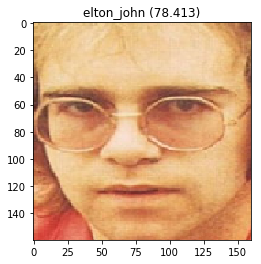

In [49]:
# возьмем случайное лицо
random_face = pixels
t = get_embedding(facenet_model, pixels)
random_face_emd = in_encoder.transform(np.asarray(t).reshape(1, -1))[0]

# предскажем
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# получим имя
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % "John")
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


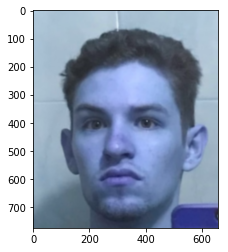

(774, 657, 3)


In [20]:
img = cv2.imread('/kaggle/input/my-photo1/vlad.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()
print(img.shape)

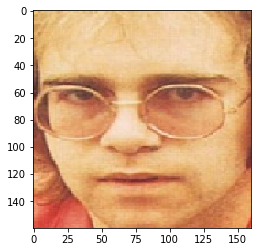

(160, 160, 3)


In [60]:
pixels_vova = extract_face('/kaggle/input/my-photo1/vlad.jpg')
plt.imshow(pixels)
plt.show()
print(pixels_vova.shape)

Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[16.69650249 23.19409821  4.0296164  36.25903079 19.82075211]
Expected: mindy_kaling


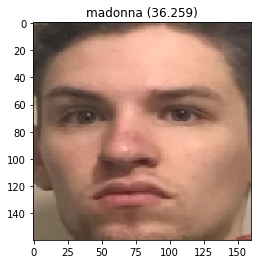

In [52]:
# возьмем случайное лицо
random_face = pixels_vova
t = get_embedding(facenet_model, pixels_vova)
random_face_emd = in_encoder.transform(np.asarray(t).reshape(1, -1))[0]


# предскажем
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# получим имя
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


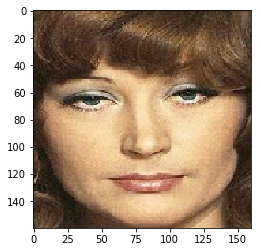

(160, 160, 3)
Predicted: 
['ben_afflek' 'elton_john' 'jerry_seinfeld' 'madonna' 'mindy_kaling'] 
[16.28415157 12.45698369  3.65285318 51.8643845  15.74162705]
Expected: ben_afflek


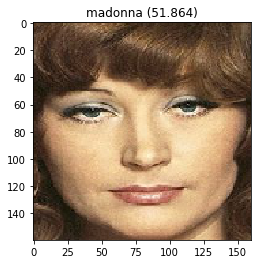

In [59]:
pixels_prim = extract_face('/kaggle/input/primad/prim.jpg')
plt.imshow(pixels_prim)
plt.show()
print(pixels_prim.shape)
# возьмем случайное лицо
random_face = pixels_prim
t = get_embedding(facenet_model, pixels_prim)
random_face_emd = in_encoder.transform(np.asarray(t).reshape(1, -1))[0]

# предскажем
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# получим имя
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()
